In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten
import joblib
import tensorflow as tf



In [4]:
rating_full_df = pd.read_csv(r'D:\WorkLab\RecSystem\data\ratings.csv')
movie_df = pd.read_csv(r'D:\WorkLab\RecSystem\data\movies.csv')

In [5]:
rating_full_df

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


In [6]:
rating_df = rating_full_df[:1000000]
rating_df.drop('timestamp', axis=1, inplace =True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15152\343773286.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df.drop('timestamp', axis=1, inplace =True)


In [7]:
unique_genres = set()
movie_df['genres'] = movie_df['genres'].apply(lambda x: x.split('|'))
movie_df['genres'].apply(unique_genres.update)
unique_genres = sorted(unique_genres)

In [8]:

for genre in unique_genres:
    movie_df[genre] = movie_df['genres'].apply(lambda x: 1 if genre in x else 0)

In [9]:
#movie_df.drop(columns=['genres'], inplace=True)

X = movie_df[unique_genres].values.astype(np.double)

# Размерность эмбеддингов
embedding_dim = 16  
X

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [10]:
input_layer = Input(shape=(len(unique_genres),))
embedding_layer = Embedding(input_dim=len(unique_genres), output_dim=embedding_dim, input_length=len(unique_genres))(input_layer)
flatten_layer = Flatten()(embedding_layer)

d:\Anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [11]:
embedding_model = Model(inputs=input_layer, outputs=flatten_layer)
embeddings = embedding_model.predict(X)
movie_df['embedding'] = embeddings.tolist()

1951/1951 ━━━━━━━━━━━━━━━━━━━━ 2s 896us/step


In [12]:
movie_df = movie_df.iloc[:, [0,1,-1]]

In [13]:
movie_df


,movieId,title,embedding
0,1,Toy Story (1995),"[0.030770722776651382, 0.021269407123327255, 0..."
1,2,Jumanji (1995),"[0.030770722776651382, 0.021269407123327255, 0..."
2,3,Grumpier Old Men (1995),"[0.030770722776651382, 0.021269407123327255, 0..."
3,4,Waiting to Exhale (1995),"[0.030770722776651382, 0.021269407123327255, 0..."
4,5,Father of the Bride Part II (1995),"[0.030770722776651382, 0.021269407123327255, 0..."
...,...,...,...
62418,209157,We (2018),"[0.030770722776651382, 0.021269407123327255, 0..."
62419,209159,Window of the Soul (2001),"[0.030770722776651382, 0.021269407123327255, 0..."
62420,209163,Bad Poems (2018),"[0.030770722776651382, 0.021269407123327255, 0..."
62421,209169,A Girl Thing (2001),"[-0.024979913607239723, 0.005861721932888031, ..."


In [14]:
full_df = rating_df.merge(movie_df, on='movieId',how='left')

In [15]:
full_df['movieId'].nunique()

21952

### **Обучаем KMeans для кластеризации фильмов**

In [16]:
def train_kmeans_model(df, n_clusters=40):

    movie_embeddings = list(df['embedding'])
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(movie_embeddings)

    df['cluster'] = clusters
    
    print(df)

    return kmeans, df, movie_embeddings, clusters

### **Получение средних рейтингов по кластерам**

In [17]:
def get_cluster_preferences(df, user_id):
    user_movies = df[df['userId'] == user_id]
    cluster_preferences = user_movies.groupby('cluster')['rating'].mean().sort_values(ascending=False)
    print(cluster_preferences)
    top_clusters = cluster_preferences.index[:3].tolist()
    
    if user_movies[user_movies['cluster'] == top_clusters[0]].shape[0] < 5:
        return top_clusters
    
    return [top_clusters[0]]

### **Генерация рекомендаций на основе кластер и рейтинг**

In [18]:
def get_recommendations(user_id, df, top_n=5):
    preferred_clusters = get_cluster_preferences(df, user_id)
    
    user_movies = df[df['userId'] == user_id]['movieId'].unique()
    recommended_movies = df[(df['cluster'].isin(preferred_clusters)) & (~df['movieId'].isin(user_movies))]
    
    top_recommendations = (
        recommended_movies.groupby(['movieId', 'title'])['rating']
        .mean()
        .sort_values(ascending=False)
        .head(top_n)
        .reset_index()
    )

    return top_recommendations

In [19]:
kmeans_model, df_with_clusters, sil_score_movie_embendings, sil_score_clusters = train_kmeans_model(full_df)

user_id = 2
recommendations = get_recommendations(user_id, df_with_clusters)
print(recommendations)


        userId  movieId  rating  \
0            1      296     5.0   
1            1      306     3.5   
2            1      307     5.0   
3            1      665     5.0   
4            1      899     3.5   
...        ...      ...     ...   
999995    6747     3566     2.0   
999996    6747     3578     5.0   
999997    6747     3593     2.0   
999998    6747     3615     4.0   
999999    6747     3623     5.0   

                                                   title  \
0                                    Pulp Fiction (1994)   
1       Three Colors: Red (Trois couleurs: Rouge) (1994)   
2       Three Colors: Blue (Trois couleurs: Bleu) (1993)   
3                                     Underground (1995)   
4                             Singin' in the Rain (1952)   
...                                                  ...   
999995                            Big Kahuna, The (2000)   
999996                                  Gladiator (2000)   
999997                          Battlef

In [20]:
df_with_clusters

,userId,movieId,rating,title,embedding,cluster
0,1,296,5.0,Pulp Fiction (1994),"[0.030770722776651382, 0.021269407123327255, 0...",20
1,1,306,3.5,Three Colors: Red (Trois couleurs: Rouge) (1994),"[0.030770722776651382, 0.021269407123327255, 0...",1
2,1,307,5.0,Three Colors: Blue (Trois couleurs: Bleu) (1993),"[0.030770722776651382, 0.021269407123327255, 0...",1
3,1,665,5.0,Underground (1995),"[0.030770722776651382, 0.021269407123327255, 0...",0
4,1,899,3.5,Singin' in the Rain (1952),"[0.030770722776651382, 0.021269407123327255, 0...",14
...,...,...,...,...,...,...
999995,6747,3566,2.0,"Big Kahuna, The (2000)","[0.030770722776651382, 0.021269407123327255, 0...",12
999996,6747,3578,5.0,Gladiator (2000),"[0.030770722776651382, 0.021269407123327255, 0...",31
999997,6747,3593,2.0,Battlefield Earth (2000),"[0.030770722776651382, 0.021269407123327255, 0...",34
999998,6747,3615,4.0,Dinosaur (2000),"[0.030770722776651382, 0.021269407123327255, 0...",29


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA

def plot_clusters(df):
    
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(sil_score_movie_embendings)

    # Добавляем уменьшенные эмбеддинги в датасет
    df['pca1'] = reduced_embeddings[:, 0]
    df['pca2'] = reduced_embeddings[:, 1]

    # Создаём кастомную палитру из 60 цветов
    custom_palette = sns.color_palette("tab20", 20) + sns.color_palette("hsv", 20)

    # Строим график
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=df, palette=custom_palette, s=60, alpha=0.7)
    plt.title('Visualization of Movie Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(loc='best', bbox_to_anchor=(1, 1), title='Clusters', ncol=3)
    plt.show()


### **Вычисление метрик**

C:\Users\ASUS\AppData\Local\Temp\ipykernel_16900\408003259.py:20: UserWarning: 
The palette list has fewer values (40) than needed (50) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=df, palette=custom_palette, s=60, alpha=0.7)


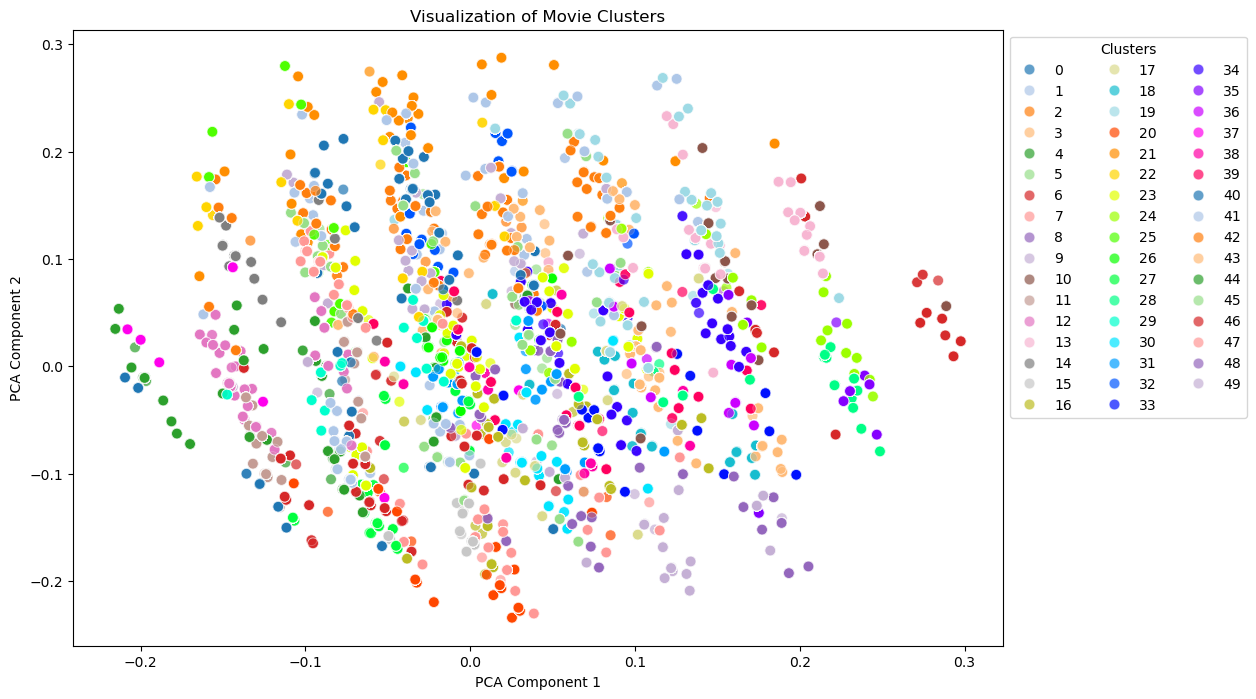

In [20]:
plot_clusters(df_with_clusters)

In [21]:
embedding_model.save('embedd_model2.keras')
#joblib.dump(kmeans_model, 'kmeans_model.pkl')

In [22]:

#sill_score = silhouette_score(sil_score_movie_embendings, sil_score_clusters)
#print(f"Silhouette Score: {sil_score}")


# Создание датасета для базы данных таблица Movie и Movie clusters

In [21]:
df_with_clusters

,userId,movieId,rating,title,embedding,cluster
0,1,296,5.0,Pulp Fiction (1994),"[0.030770722776651382, 0.021269407123327255, 0...",20
1,1,306,3.5,Three Colors: Red (Trois couleurs: Rouge) (1994),"[0.030770722776651382, 0.021269407123327255, 0...",1
2,1,307,5.0,Three Colors: Blue (Trois couleurs: Bleu) (1993),"[0.030770722776651382, 0.021269407123327255, 0...",1
3,1,665,5.0,Underground (1995),"[0.030770722776651382, 0.021269407123327255, 0...",0
4,1,899,3.5,Singin' in the Rain (1952),"[0.030770722776651382, 0.021269407123327255, 0...",14
...,...,...,...,...,...,...
999995,6747,3566,2.0,"Big Kahuna, The (2000)","[0.030770722776651382, 0.021269407123327255, 0...",12
999996,6747,3578,5.0,Gladiator (2000),"[0.030770722776651382, 0.021269407123327255, 0...",31
999997,6747,3593,2.0,Battlefield Earth (2000),"[0.030770722776651382, 0.021269407123327255, 0...",34
999998,6747,3615,4.0,Dinosaur (2000),"[0.030770722776651382, 0.021269407123327255, 0...",29


In [23]:
average_ratings = df_with_clusters.groupby('movieId')['rating'].mean().reset_index()


In [24]:
average_ratings.rename(columns={'rating':'mean_rating'}, inplace=True)

In [25]:
average_ratings

,movieId,mean_rating
0,1,3.893554
1,2,3.310185
2,3,3.162768
3,4,2.936170
4,5,3.135542
...,...,...
21947,208002,3.500000
21948,208080,3.000000
21949,208737,3.500000
21950,208793,3.500000


In [26]:
Movie = df_with_clusters.merge(average_ratings)

In [27]:
Movie.drop(axis=1, columns=['rating', 'userId', 'embedding'], inplace=True)

In [28]:
Movie

,movieId,title,cluster,mean_rating
0,296,Pulp Fiction (1994),20,4.175573
1,306,Three Colors: Red (Trois couleurs: Rouge) (1994),1,4.070707
2,307,Three Colors: Blue (Trois couleurs: Bleu) (1993),1,3.949187
3,665,Underground (1995),0,3.948276
4,899,Singin' in the Rain (1952),14,4.070922
...,...,...,...,...
999995,3566,"Big Kahuna, The (2000)",12,3.419643
999996,3578,Gladiator (2000),31,3.971815
999997,3593,Battlefield Earth (2000),34,1.715152
999998,3615,Dinosaur (2000),29,3.105691


In [29]:
movie_df = pd.read_csv('D:\WorkLab\RecSystem\data\movies.csv')

<>:1: SyntaxWarning: invalid escape sequence '\W'
<>:1: SyntaxWarning: invalid escape sequence '\W'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15152\1679190829.py:1: SyntaxWarning: invalid escape sequence '\W'
  movie_df = pd.read_csv('D:\WorkLab\RecSystem\data\movies.csv')


In [35]:
Movie = Movie.merge(movie_df)

ValueError: You are trying to merge on float64 and object columns for key 'genres'. If you wish to proceed you should use pd.concat

In [37]:
Movie.columns=['movieId', 'title', 'cluster', 'mean_rating', 'genres']

In [38]:
Movie = Movie[['movieId', 'title', 'mean_rating', 'genres', 'cluster']]

In [44]:
Movie.iloc[: , 0:]

,movieId,title,mean_rating,genres,cluster
0,296,Pulp Fiction (1994),4.175573,Comedy|Crime|Drama|Thriller,20
1,306,Three Colors: Red (Trois couleurs: Rouge) (1994),4.070707,Drama,1
2,307,Three Colors: Blue (Trois couleurs: Bleu) (1993),3.949187,Drama,1
3,665,Underground (1995),3.948276,Comedy|Drama|War,0
4,899,Singin' in the Rain (1952),4.070922,Comedy|Musical|Romance,14
...,...,...,...,...,...
999995,3566,"Big Kahuna, The (2000)",3.419643,Comedy|Drama,12
999996,3578,Gladiator (2000),3.971815,Action|Adventure|Drama,31
999997,3593,Battlefield Earth (2000),1.715152,Action|Sci-Fi,34
999998,3615,Dinosaur (2000),3.105691,Adventure|Animation|Children,29


In [ ]:
Movie['genres'] = Movie['genres'].apply(lambda x: '{' + ','.join(x.split('|')) + '}')



In [50]:
Movie.to_csv('datasets_for_db_movie.csv', index=False)